In [1]:
# ===================================================================
#                          METADATA
# ===================================================================

# -------------------- General Information --------------------------
# 1. Title: Figure Script
# 2. Description: Script to reproduce Figure 4 in the article
# "Ionic Liquid--Electrode Interface: from One Law To Fit Them All to One Model To Predict Them All".
# 3. Authors:
#    - Ba Long Nguyen (ORCID: 0009-0003-7682-9851)
#    - Vladislav Ivanistsev (ORCID: 0000-0003-4517-0540)
# 4. Contact: balongn99@gmail.com & vladislav.ivanistsev@gmail.com
# 5. Keywords: differential capacitance, ionic liquids, modelling, fitting.

# -------------------- Identifiers & Versioning ---------------------
# 6. Version: 1.0.0
# 7. Date: 
#    - Created: 2025-06-13
#    - Last Modified: 2025-09-24
# 8. DOI: https://doi.org/10.1016/j.elecom.2025.108049

# -------------------- Usage & Accessibility ------------------------
# 10. License: This work is licensed under the MIT License.
# 11. Dependencies:
#     - Python 3.8+
#     - See 'requirements.txt' for necessary libraries (e.g., numpy, pandas, scipy, matplotlib).
# 13. Data Format:
#     - Units: Potential (V), Capacitance (μF/cm²), Surface Charge Density (μC/cm²)

In [2]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares
l = 8.25/2.54 # inches
plt.rc('figure',figsize=(l,l)) # figure size
plt.rc('figure',      dpi=500) # figure dpi
plt.rc('lines',  linewidth=1)  # linewidth
plt.rc('font',        size=10) # fontsize of the text
plt.rc('font', family='sans-serif') # font family
plt.rc('axes',   titlesize=10) # fontsize of the axes title
plt.rc('axes',   labelsize=9)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=8)  # fontsize of the tick labels
plt.rc('ytick',  labelsize=8)  # fontsize of the tick labels
plt.rc('legend', fontsize =9)  # fontsize of the legend
plt.rc('figure', titlesize=10) # fontsize of the figure title

In [3]:
# ──────────────────── DATASETS ────────────────────
data_TFSAN1444 = {
  "U": np.array([
    -8.9566823, -8.2478534, -7.5539807, -6.893926, -6.2196714, -5.5059203,
    -4.8100116, -4.1775398, -3.4441147, -2.8285412, -2.2661154, -1.718025,
    -1.2206901, -0.86129428, -0.44734986, -0.12596974, 0.20473219, 0.56724145,
    0.94385464, 1.3417375, 1.6843227, 2.1589204, 2.6623967, 3.1896993,
    3.6999483, 4.3729092, 5.1801261, 5.9271759, 6.9324836, 7.8293742, 8.720207
]),
  "C": np.array([
    4.0440597, 4.2699344, 4.4371021, 4.4434628, 4.4061309, 4.4277104, 4.403857,
    4.5079396, 4.7067409, 4.9690282, 5.4515596, 6.0836948, 6.7411088, 7.6555108,
    8.4480979, 8.6335089, 8.7168063, 8.2449322, 8.1143354, 7.7211142, 7.1213932,
    6.4818836, 5.9850114, 5.5431609, 4.8718318, 4.3559651, 3.7779067, 3.4962842,
    3.3728672, 3.2710784, 3.2918675
]),
  "dC": np.array([
    0.048239195, 0.021492575, 0.01773176, 0.034016327, 0.020275244,
    0.047142588, 0.064669462, 0.073382852, 0.097048716, 0.059920953,
    0.019793531, 0.10805177, 0.15825102, 0.18622275, 0.17393211,
    0.22257698, 0.028241537, 0.022404077, 0.11721826, 0.20736835,
    0.16374179, 0.11214443, 0.040034989, 0.1161786, 0.094479814,
    0.10253857, 0.076653153, 0.075149379, 0.084504154, 0.04054821,
    0.031657104
])
}
data_TFSAN4444 = {
  "U": np.array([
    -8.8654072, -7.9306557, -7.0050661, -6.1780256, -5.4940108, -4.666761,
    -3.8733266, -3.1571084, -2.3580143, -1.7975436, -1.2521956, -0.81373714,
    -0.4094232, -0.057718006, 0.28247906, 0.6662099, 1.0233817, 1.3942538,
    1.7239589, 2.2702502, 2.7017659, 3.1950107, 3.737417, 4.3554723,
    5.0972423, 6.0656409, 6.8587863
]),
  "C": np.array([
    3.0441661, 3.2481886, 3.5657465, 3.7689075, 3.8969208, 3.9540713, 3.8935489,
    4.1769831, 4.5893008, 5.2306263, 6.2075039, 7.009428, 7.9203937, 8.2969356,
    8.4406954, 8.3125825, 8.3906745, 7.7516559, 7.1579263, 6.616438, 6.1187754,
    5.8196756, 5.0907541, 4.266671, 3.8089723, 3.454309, 3.3070536
]),
  "dC": np.array([
    0.0455846, 0.01767655, 0.039734544, 0.090192538, 0.073133347, 0.082483908,
    0.049458109, 0.099132595, 0.11216115, 0.11354059, 0.05854256, 0.073762804,
    0.046726256, 0.1544541, 0.082359485, 0.082520473, 0.063849271, 0.3294166,
    0.28049373, 0.25208701, 0.15630168, 0.016031754, 0.045311861, 0.064660344,
    0.11975131, 0.082470792, 0.20614735
])
}


# s_M for negative branches:
sM_vals = {
    "$\\mathrm{N_{1114}}^+$": -62.9,   # N1114
    "$\\mathrm{N_{1144}}^+$": -43.5    # N1144
}

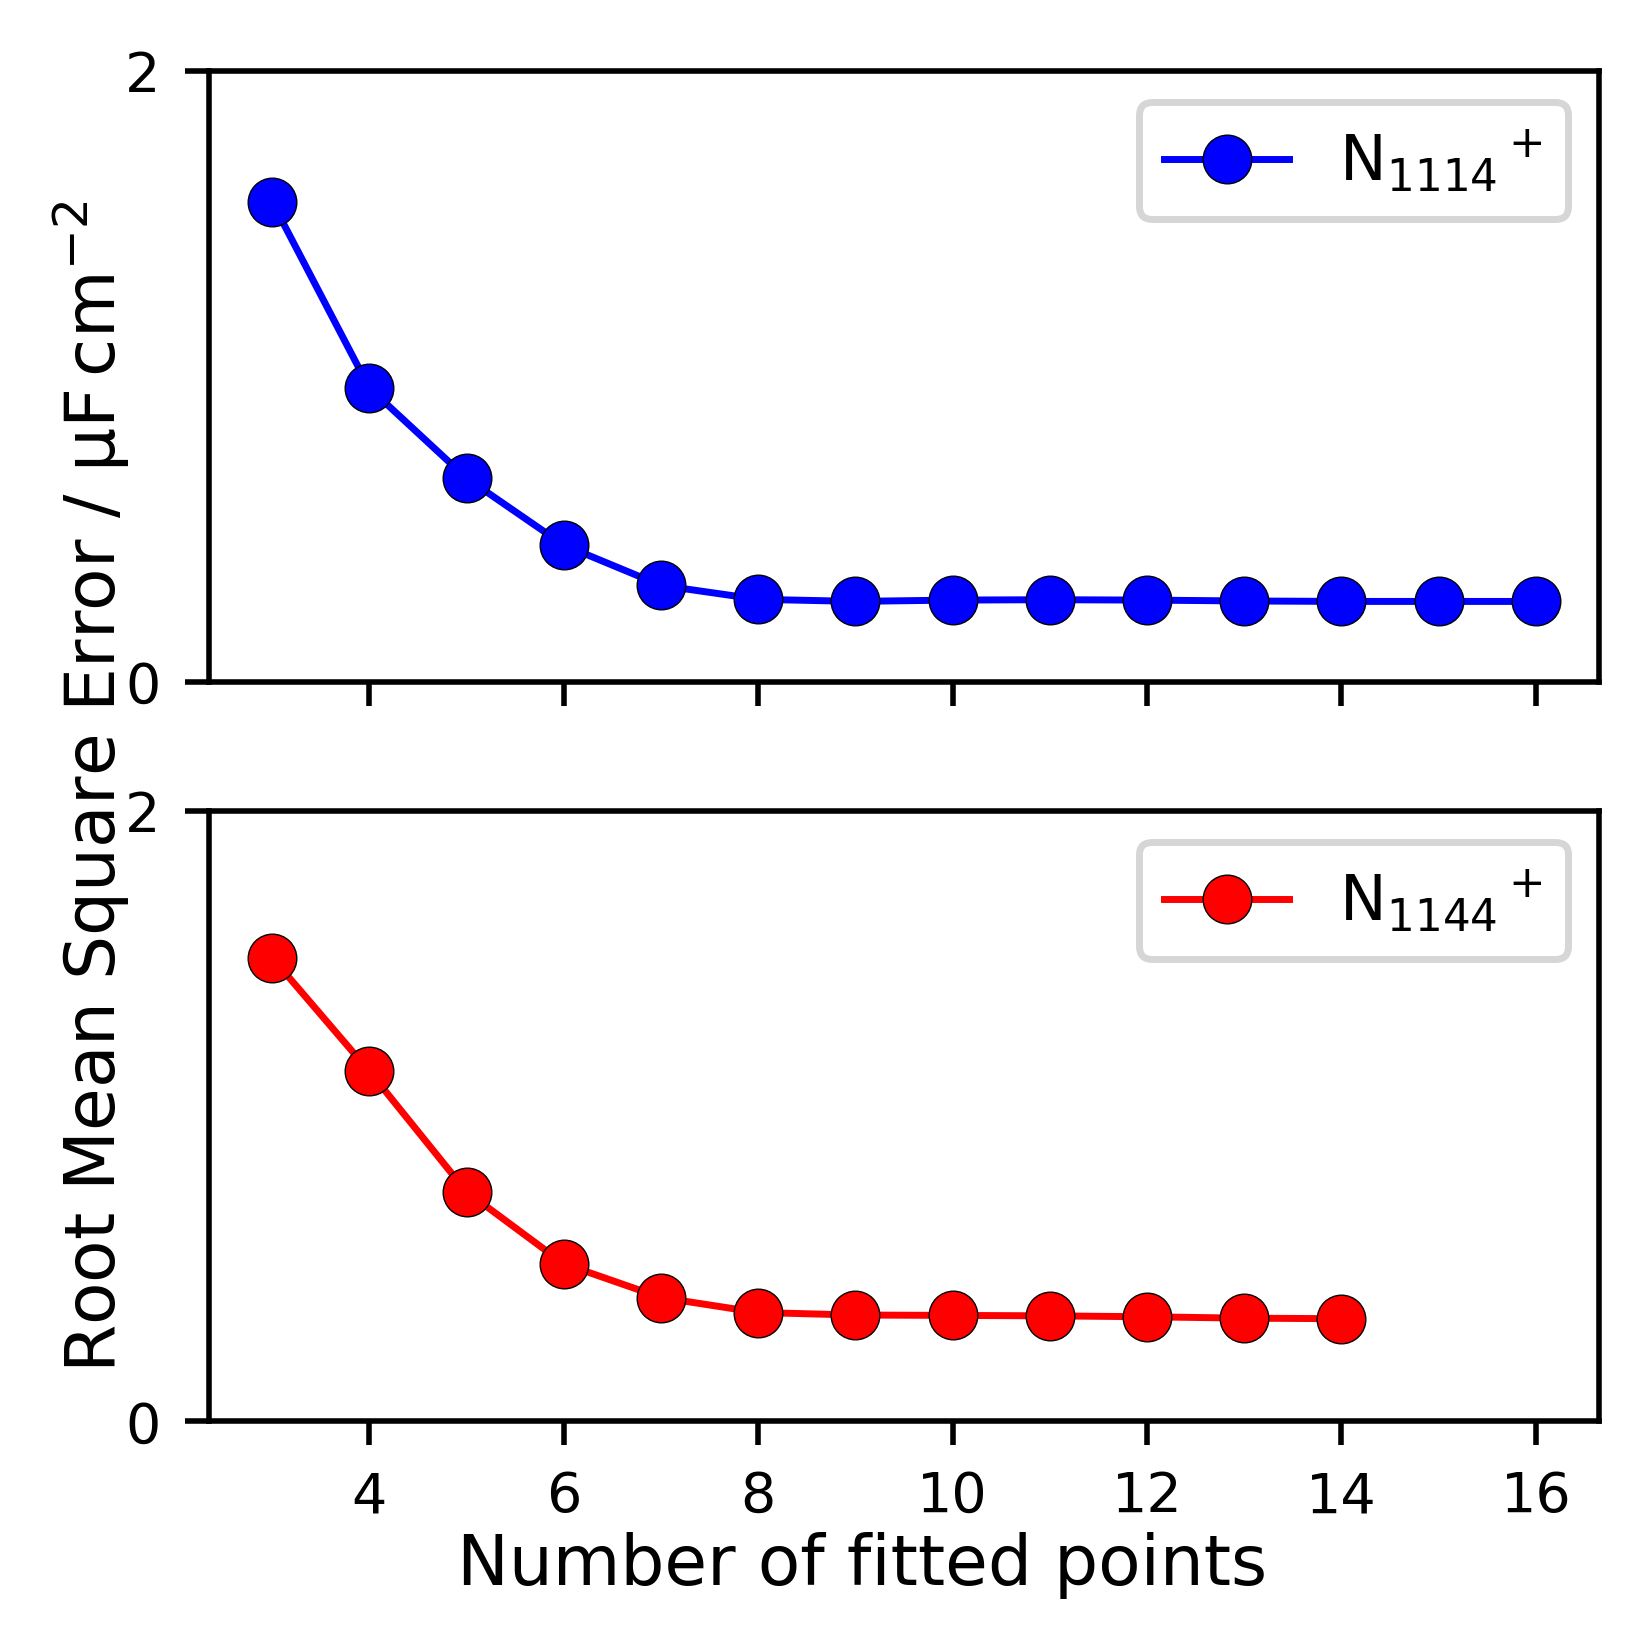

In [4]:
colors = ['blue', 'red']
# capacitance & residuals
def capacitance(u, sM, uM, k1, k2):
    a  = k1 + (1 - k1) * np.exp(-k2 * u / uM)
    ap = (1 - k1) * (-k2 / uM) * np.exp(-k2 * u / uM)
    return sM * (u / uM)**a * (a / u + ap * np.log(u / uM))

def make_residuals(sM):
    def res(p, U_sub, C_sub):
        uM, k1, k2 = p
        # enforce negative‐branch uM<0
        if uM >= 0:
            return np.full_like(C_sub, 1e6)
        return capacitance(U_sub, sM, uM, k1, k2) - C_sub
    return res

def compute_rmse_curve(U, C, sM):
    """Return (subset sizes, rmse) for the negative branch."""
    # sort by |U|, pick U<0
    mask = U < 0
    Un, Cn = U[mask], C[mask]
    order = np.argsort(np.abs(Un))
    Un, Cn = Un[order], Cn[order]

    res_fun = make_residuals(sM)
    sizes, rmses = [], []
    for n in range(3, len(Un)+1):
        idx = order[:n]
        U_sub, C_sub = Un[:n], Cn[:n]

        # DE + refine
        lb, ub = [-15, 0, 0], [-1e-2, 1, 1000]
        de = differential_evolution(lambda p: np.sum(res_fun(p, U_sub, C_sub)**2),
                                    bounds=list(zip(lb, ub)), maxiter=500, seed=0)
        ls = least_squares(res_fun, x0=de.x, args=(U_sub, C_sub), bounds=(lb, ub))

        # full‐branch RMSE
        Cp = capacitance(Un, sM, *ls.x)
        rmse = np.sqrt(np.mean((Cp - Cn)**2))
        sizes.append(n)
        rmses.append(rmse)

    # filter extreme outliers
    arr = np.array(rmses)
    keep = arr <= 10 * arr.min()
    return np.array(sizes)[keep], np.array(rmses)[keep]

# --- plot ---
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

for ax, (label, data), col in zip(
        axs,
        [("$\\mathrm{N_{1114}}^+$", data_TFSAN1444), ("$\\mathrm{N_{1144}}^+$", data_TFSAN4444)],
        colors
    ):
    U, C = data["U"], data["C"]
    sz, rm = compute_rmse_curve(U, C, sM_vals[label])

    ax.plot(
        sz,
        rm,
        'o-',         
        color=col,  
        label=f"{label}",
        markeredgecolor='black', markeredgewidth=0.2, markersize=7
    )
    ax.set_ylim(0, 1.7)
    ax.set_yticks([0, 2])
    ax.legend()



# shared X label
fig.text(0.5,    
         0,    
         "Number of fitted points",
         ha='center',
         va='bottom',
         )

# shared Y label
fig.text(0,   
         0.5,
         "Root Mean Square Error / $\\mathrm{\\mu F\\,cm^{-2}}$",
         ha='left',
         va='center',
         rotation='vertical',
         )

plt.tight_layout()
# plt.savefig("Figure_4_RMSE1.pdf", dpi=600, bbox_inches='tight')
plt.show()
